In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/horse1/horse.jpeg
/kaggle/input/dog-fight/dog-snarl.jpg
/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/

In [2]:
import tensorflow as tf

2024-04-13 16:14:51.986987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 16:14:51.987106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 16:14:52.147918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [5]:
BASE_DIR='/kaggle/input/flickr8k'
WORKING_DIR='/kaggle/working'

In [6]:
## load vgg16 model

model=VGG16()

## restructure the model

model=Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
## extract features from image

features = {}
directory = os.path.join(BASE_DIR,'Images')


for img_name in tqdm(os.listdir(directory)):
    ## load the image from file
    img_path=directory + '/'+ img_name
    image=load_img(img_path,target_size=(224,224))
    
    ## convert image pixels to numpy array
    image=img_to_array(image)
    
    ## reshape data for model
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    
    ## preprocesss image for vgg
    ##This line preprocesses the image for the VGG16 model using the preprocess_input function. 
    #This function preprocesses the image data to make it suitable for input to the VGG16 model.
    image=preprocess_input(image)
    
    ## extract features
    feature = model.predict(image,verbose=0)
    
    ## get the image ID
    image_id=img_name.split('.')[0]
    
    ## store feature
    features[image_id]= feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1713025110.179787      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
## store features in pickle
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [9]:
## load features from pickle
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features=pickle.load(f)

## Load the Captions Data

In [10]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    captions_doc=f.read()

In [11]:
## create mapping of image to captions

mapping={}

## process lines

for line in tqdm(captions_doc.split('\n')):
    ## split the line by comma(,)
    token=line.split(',')
    if len(line)<2:
        continue
    image_id,caption=token[0],token[1:]
    ## remove extension from image_id
    image_id=image_id.split('.')[0]
    ## convert the caption list into string
    caption=" ".join(caption)
    ## create list if needed
    if image_id not in mapping:
        mapping[image_id]=[]
        
    ## store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)

8091

## Preprocess Text Data

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            ## take one caption at a time
            caption=captions[i]
            ## preprocessing steps
            ## convert to lowercase
            caption=caption.lower()
            ## delete digits,special char,etc.,
            caption=caption.replace('[^A-Za-z]','')
            ## delete additional spaces
            caption=caption.replace('\s+',' ')
            ## add start and end tags to the caption
            caption='startseq '+" ".join([word for word in caption.split() if len(word)>1])+ ' endseq'
            captions[i]=caption

In [14]:
## before preprocess of text 
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [15]:
## Preprocess the text
clean(mapping)

In [16]:
## After preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [17]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [18]:
len(all_captions)

40455

In [19]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [20]:
## tokenize the text 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [21]:
vocab_size

8485

In [22]:
## Get maximum length of the cption available
max_length=max(len(caption.split())for caption in all_captions)
max_length

35

## Train Test Split

In [23]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]

In [24]:

# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [25]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    ## Loop over images
    X1,X2,y=list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions=mapping[key]
            ## process each caption
            for caption in captions:
                ## Encode output sequence into X,y pairs
                seq=tokenizer.texts_to_sequences([caption])[0]
                ## split the sequences into X and y pairs
                for i in range(1,len(seq)):
                    ## split into input and output pairs
                    in_seq,out_seq= seq[:i],seq[i]
                    # encode output sequence
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
                    ## encode output sequence
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
                    
                    ## store the sequences 
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1,X2,y=np.array(X1),np.array(X2),np.array(y)
                yield {"image":X1,"text":X2},y
                X1,X2,y=list(),list(),list()
                n=0

## Model Creation

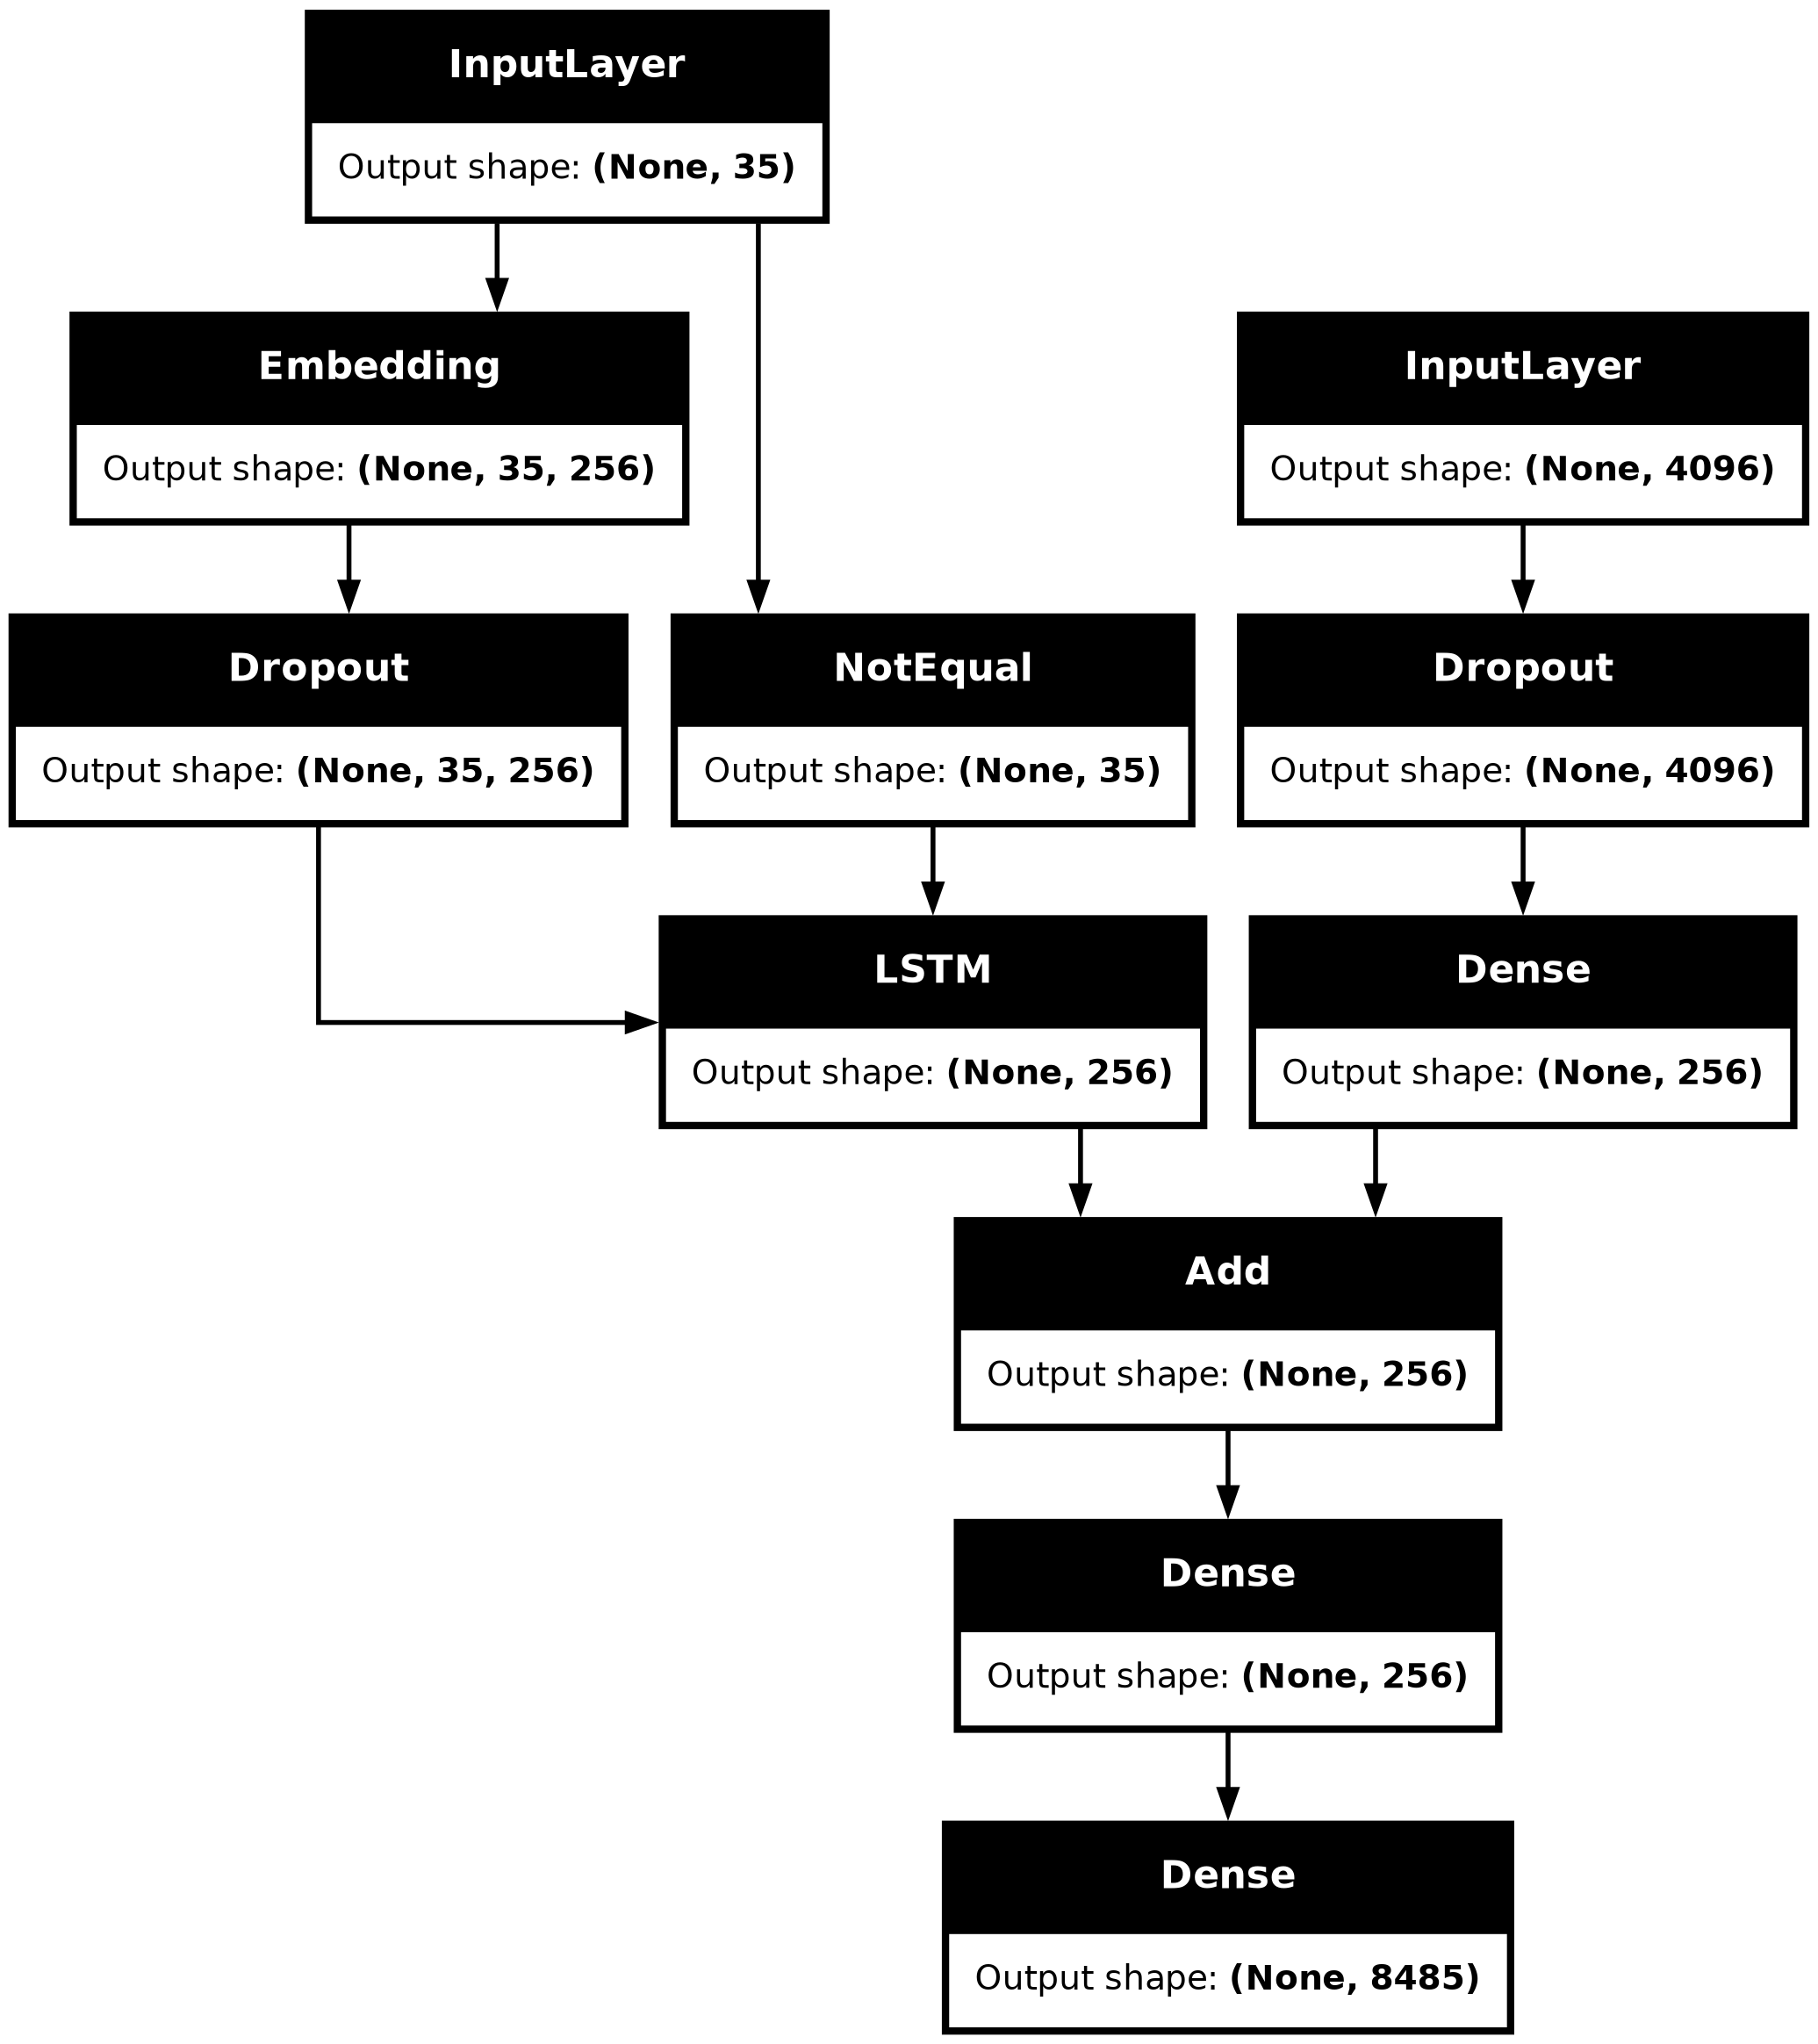

In [28]:
## encoder model
## image feature layers
inputs1 = Input(shape=(4096,),name="image")
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)

## sequence feature layers
inputs2 = Input(shape=(max_length,),name="text")
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)

## decoder model
decoder1= add([fe2,se3])
decoder2= Dense(256, activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

## plot the model
plot_model(model,show_shapes=True)

In [29]:
# Train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # Create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # Fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 66s 269ms/step - loss: 5.7781
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - loss: 4.0604
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 3.5917
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 3.3042
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - loss: 3.0933
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.9425
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 2.8252
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.7291
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - loss: 2.6497
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 2.5813
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.5204
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.4679
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 262ms/step - loss: 2.4187
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 2.3692
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.3268
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - loss: 2.2840
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - loss: 2.24

In [30]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

Generate Caption for Image

In [31]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [32]:
## Generate caption for an image 
def predict_caption(model,image,tokenizer,max_length):
    ## add start tag for generation process
    in_text='startseq'
    ## iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        #predict the next word
        yhat=model.predict([image,sequence],verbose=0)
        # get the index with high probability
        yhat=np.argmax(yhat)
        ## convert index to word
        word=idx_to_word(yhat,tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text +=" "+ word
        # stop if we reach end tag
        if word == 'endseq':
            break
            
    return in_text

In [33]:
from nltk.translate.bleu_score import corpus_bleu

#validate with test data
actual,predicted =list(),list()

for key in tqdm(test):
    #get actual caption 
    captions =mapping[key]
    # predict the caption for image
    y_pred=predict_caption(model,features[key],tokenizer,max_length)
    # split into words
    actual_caption=[caption.split() for caption in captions]
    y_pred=y_pred.split()
    # append to the list 
    actual.append(actual_caption)
    predicted.append(y_pred)
    
    
    
    
## calculate BLUE score
print("BLEU-1: %f" % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.529088
BLEU-2: 0.309857


In [35]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in pigtails is spinning on the slide endseq


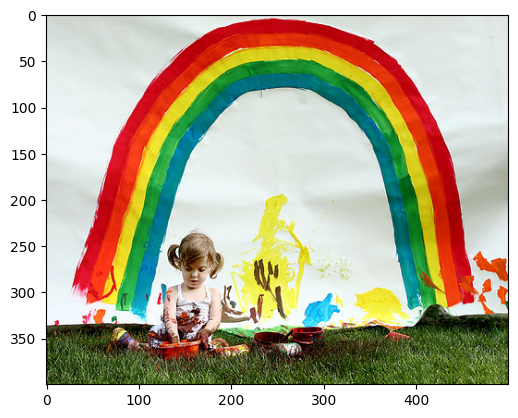

In [42]:
generate_caption('1002674143_1b742ab4b8.jpg')

In [38]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [51]:
image_path = '/kaggle/input/dog-fight/dog-snarl.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq two dogs are playing in the snow endseq'